# Brief tutorial

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/My Drive/Wave_propogation

/content/drive/My Drive/Wave_propogation


In [ ]:
!pip install GPUtil

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pickle

import torch
from PIL import Image
import torchvision.transforms as transforms

# from utils import  Simulation, get_vp, ParamsGenerator

from train_utils import get_batch, train, validate#, test
from plottings import show_grig
from IPython.display import clear_output
from time import gmtime, strftime
from utils import save_model, model_best, load_model

import torch.nn as nn
import torch.nn.functional as F

from models import WaveAE, WaveGRUModel, WaveLSTMModel
from losses import WaveLoss
import torch, torch.nn as nn
import GPUtil
from torch import optim 
from plottings import plot_metrics, plot_test_video
from utils import load_metrics
from test import test_diff_model__

%load_ext autoreload
%autoreload 2

In [ ]:
device = 'cpu' if not torch.cuda.is_available() else 'cuda'
device

'cpu'

# Available models


1.   Vanilla Autoencoder (WaveAE)
2.   Convolutional GRU (WaveGRUModel)
3.   Convolutional LSTM (WaveLSTMModel)

All models accepts learneble prooning






# Example to load model

Firstly, you need to choose the structure of model that you want to load. For example, If you want to load WaveAE model with MaxPool2d pooling, ELU activation function and pruning mode you must to find *.pth file with title that contain this keywords and load model.

In [ ]:
epoch = 5
loss_hist = {'train': [],
             'val': []}

metrix_coeff = {'correlation': [],
                'RMSE': []}


Epoch: 400, train loss: 0.1694383777678013, val loss: 0.08632775098085403
(tensor(20.8333), 144, tensor([0.0527], grad_fn=<SigmoidBackward>))
(tensor(23.6111), 4608, tensor([0.0026], grad_fn=<SigmoidBackward>))
(tensor(37.5217), 4608, tensor([0.0150], grad_fn=<SigmoidBackward>))
(tensor(12.5000), 144, tensor([0.0219], grad_fn=<SigmoidBackward>))


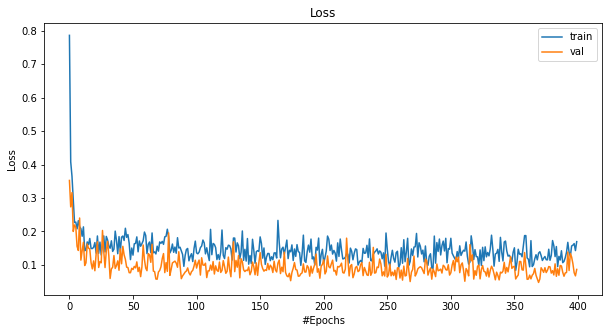

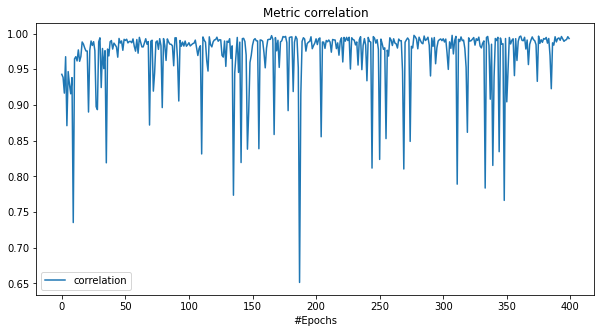

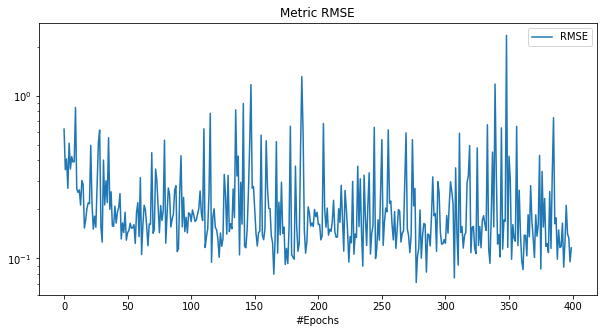

In [ ]:


epoch_time_nn = [1]
epoch_time_fd = [1]

model = WaveAE(in_channels=1, bottle_neck=32, n_layers=2, kernel_size=3,
              pooling=nn.MaxPool2d, activation=nn.ELU, pruning=True)

model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-3)

loss_hist, metrix_coeff, epoch = load_model('./checkpoints/AE/pruning_MaxPool2d_ELU_LAST_WaveAE_KeyboardInterrupt_2020-11-21 15_06_47.pth', model, optimizer, loss_hist, metrix_coeff)
plot_metrics(model, epoch, loss_hist, metrix_coeff)



Epoch: 29, train loss: 0.6958340287208558, val loss: 0.77426518201828


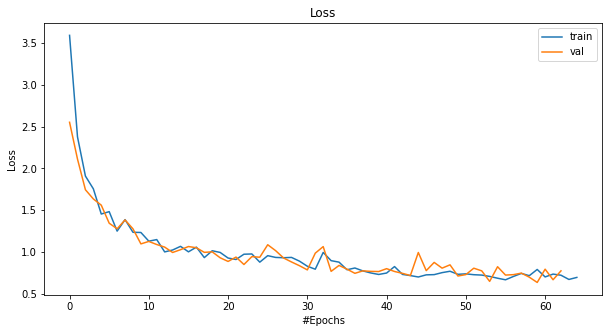

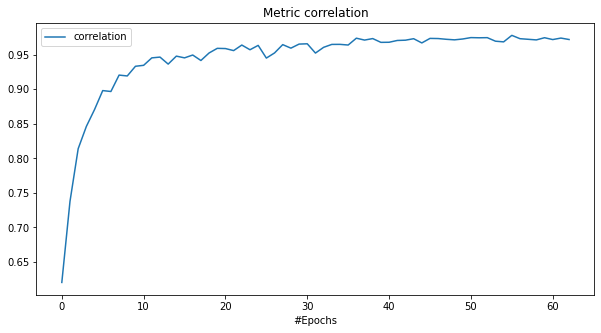

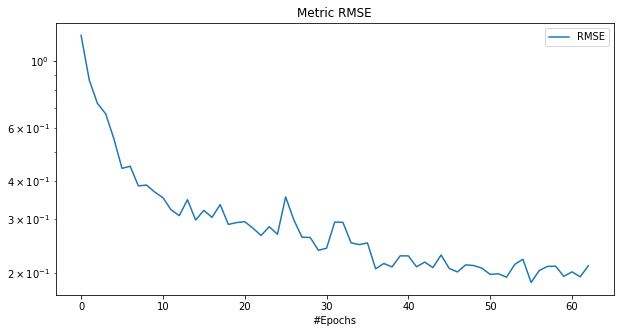

In [ ]:
h_control = {'ord': 'l1', 'lam': 0.}
model = WaveLSTMModel(bottle_neck=32, rnn_channels=32, n_layers=2, kernel_size=3,
                     pooling=nn.MaxPool2d, activation=nn.ELU, pruning=False, 
                     mode='fast', hidden_control=h_control)

model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-3)

loss_hist, metrix_coeff, epoch = load_model('./checkpoints/LSTM_TRY_no_pruning_L1WaveLSTMModel_KeyboardInterrupt_2020-12-06 14_21_03.pth', model, optimizer, loss_hist, metrix_coeff)
plot_metrics(model, epoch, loss_hist, metrix_coeff)

# Loss function


1.   l1 norm (l1)
2.   l2 norm (l2)
3.   infinity norm (inf) 



In [ ]:
loss = WaveLoss(order='l1', factor=None)

# Train model

To save you model add title in parameter 'add_name' \\
Set the parameters for generation solution by differences method and batch generation

In [ ]:
add_name = 'Example'
N_min = 4.
N_max = 6.
nx, nz, nt = 80, 80, 25

batch_size = 8
n_epochs = 1000
# n_epochs = 400
n_batches_per_epoch = 10
n_validation_batches = 5

In [ ]:
import gc
# del batch
gc.collect()
torch.cuda.empty_cache()

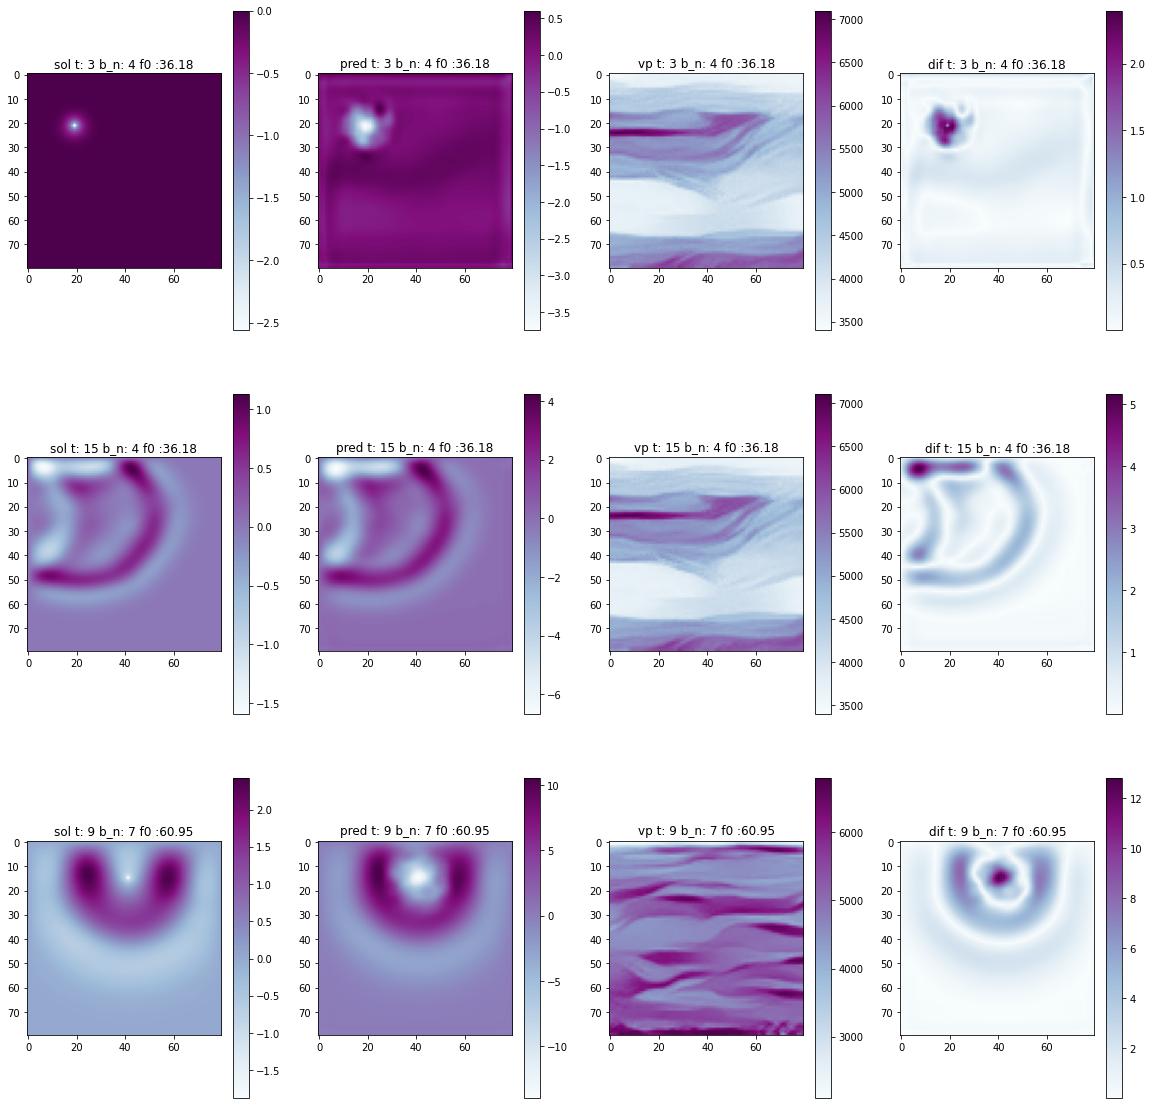


Parameters of the model and optimizer are saved to file --> ./checkpoints/ExampleWaveLSTMModel_best_train_best_val_best_correlation_best_RMSE.pth


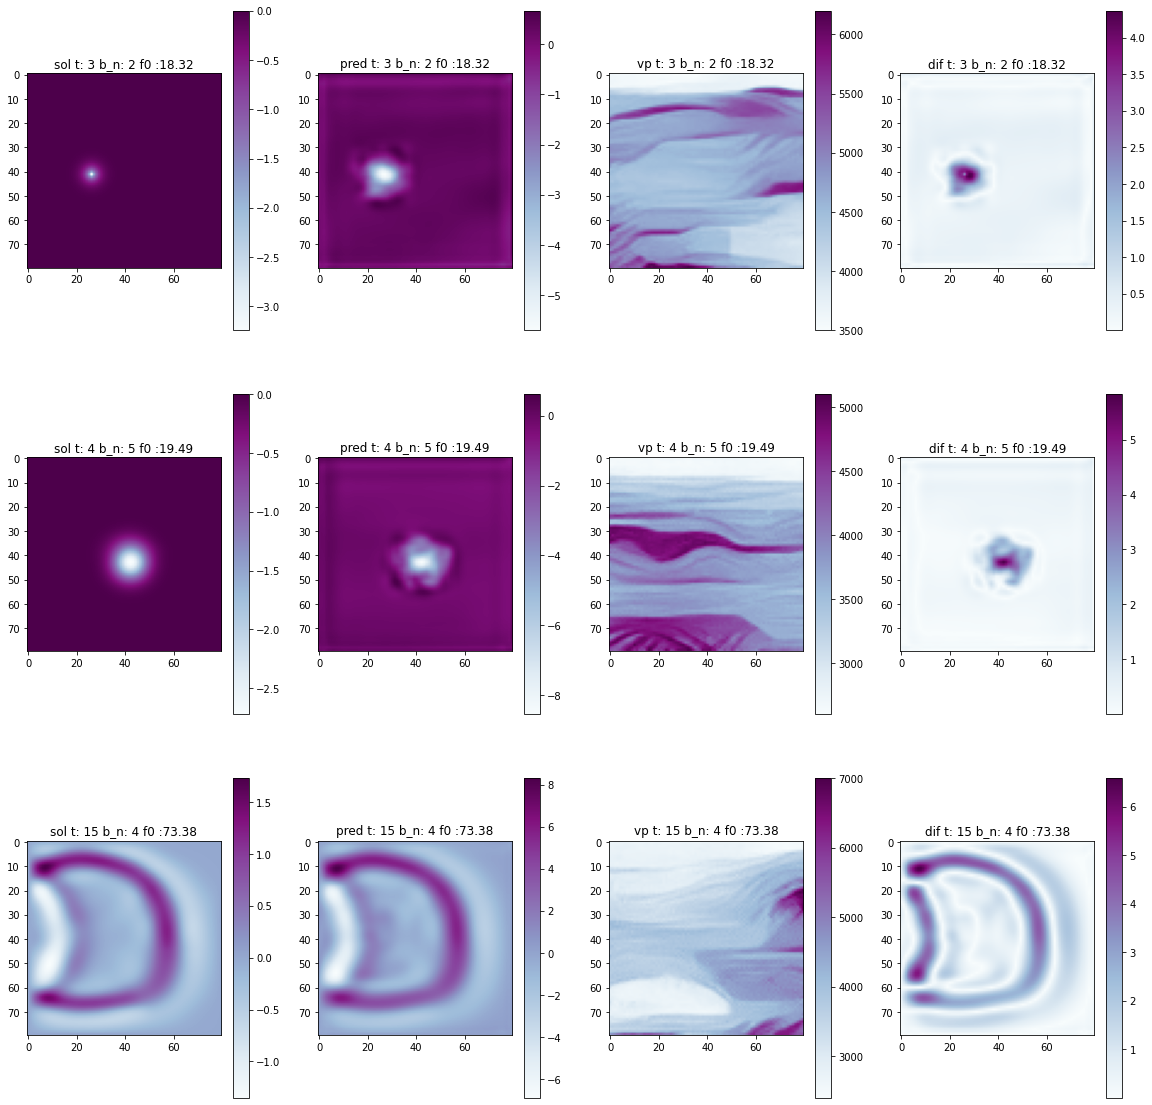



Epoch: 1, train loss: 1.712991189956665, val loss: 1.5276065587997436


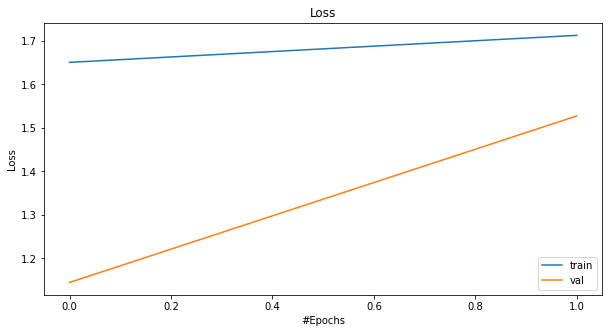

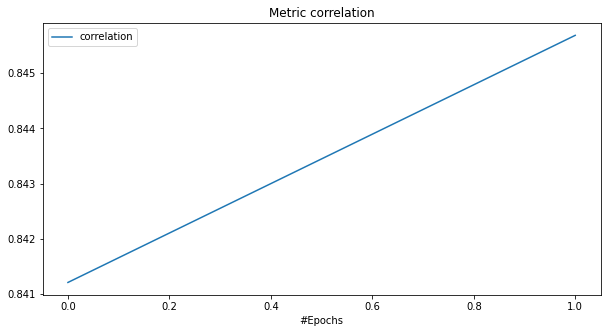

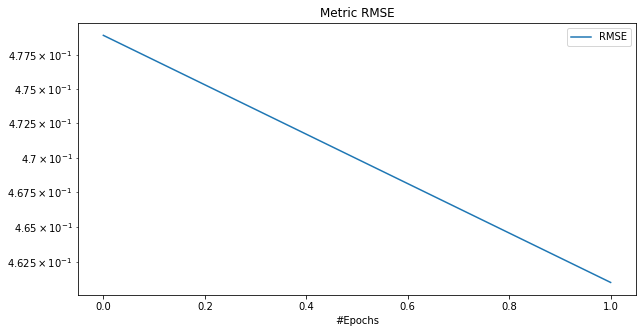

Parameters of the model and optimizer are saved to file --> ./checkpoints/ExampleWaveLSTMModel_best_correlation_best_RMSE.pth





...
KeyboardInterrupt error: model saving started!
Parameters of the model and optimizer are saved to file --> ./checkpoints/ExampleWaveLSTMModel_KeyboardInterrupt_2020-12-06 20:39:24.pth
Parameters of the model and optimizer are saved to file --> ./checkpoints/Example_LAST_WaveLSTMModel_KeyboardInterrupt_2020-12-06 20:39:24.pth


In [ ]:
loss_hist = {'train': [],
             'val': []}

metrix_coeff = {'correlation': [],
                'RMSE': []}

epoch_time_nn = []
epoch_time_fd = []


try :
  for epoch in tqdm(range(n_epochs)):
    
    train(model, optimizer, loss_hist, epoch_time_nn, N_min, N_max, nx, nz, nt,
            epoch_time_fd, n_batches_per_epoch, batch_size, device, loss)
    
    if epoch % 5 == 0:
      clear_output()

    validate(model, optimizer, loss_hist, n_validation_batches, 
            device, N_min, N_max, nx, nz, nt, loss, batch_size, metrix_coeff)
    
    plot_metrics(model, epoch, loss_hist, metrix_coeff)
    result = model_best(loss_hist, metrix_coeff)

    if result != []:
      save_model(epoch, model, optimizer, loss_hist, metrix_coeff, best_names=result, KI=False, add_name=add_name)

except KeyboardInterrupt:
  print('\n\n\n...\nKeyboardInterrupt error: model saving started!')
  save_model(epoch, model, optimizer, loss_hist, metrix_coeff, best_names=[], KI=True, add_name=add_name)  

save_model(epoch, model, optimizer, loss_hist, metrix_coeff, best_names=[], KI=True, add_name=add_name+'_LAST_')

# Test model

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


<class 'torch.Tensor'>


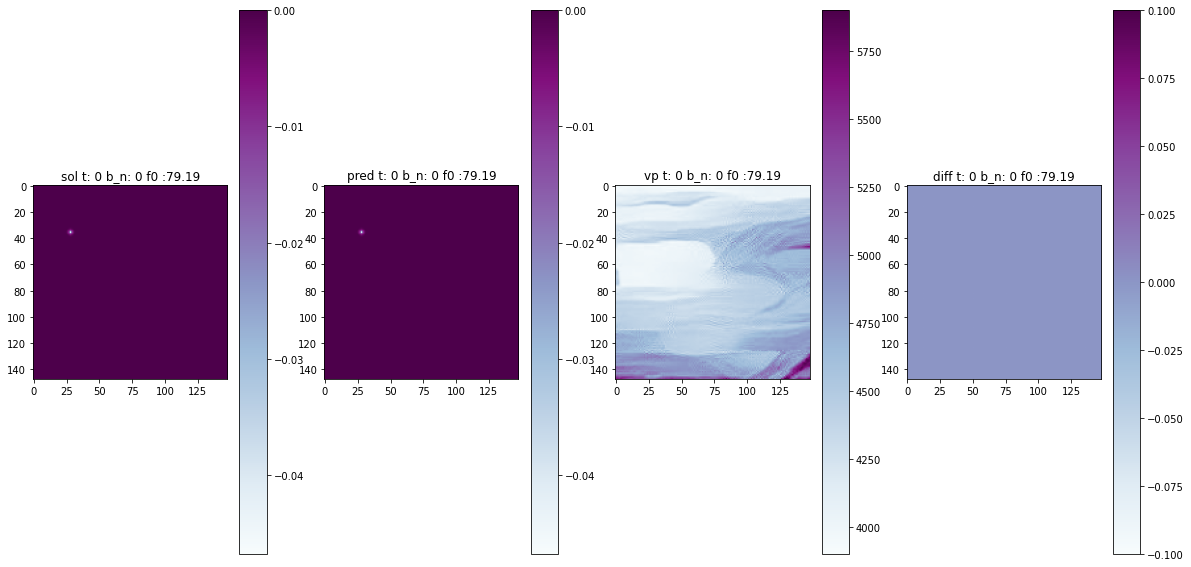

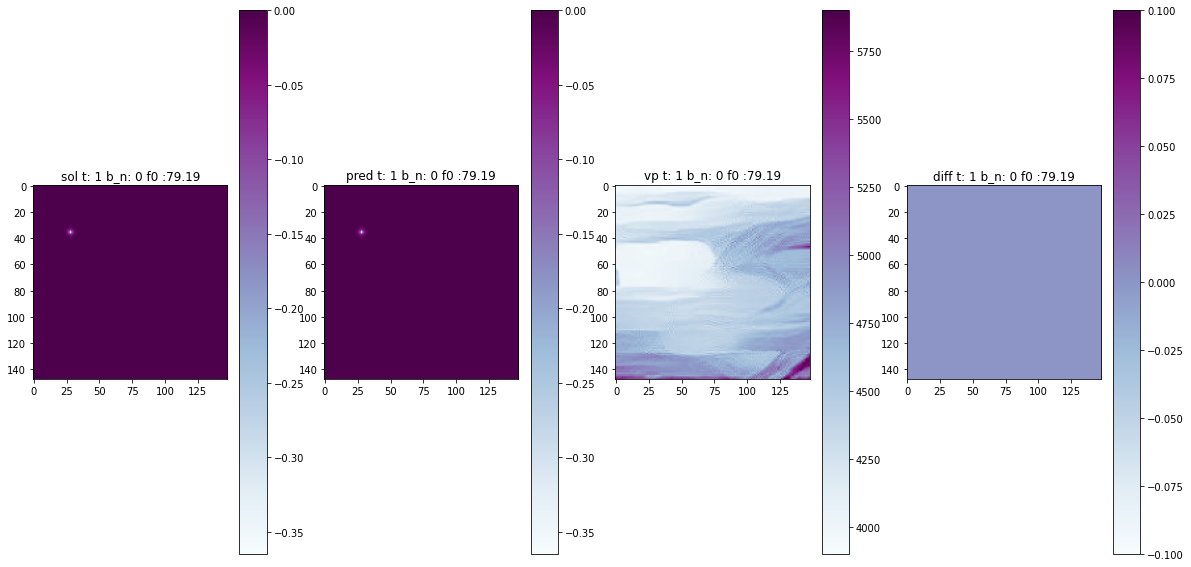

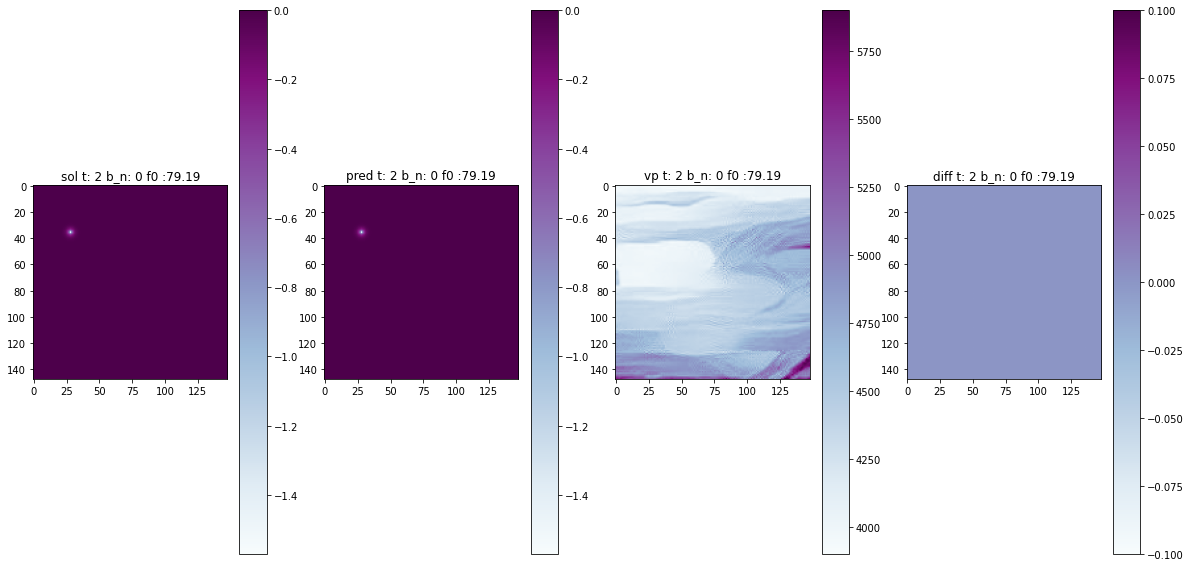

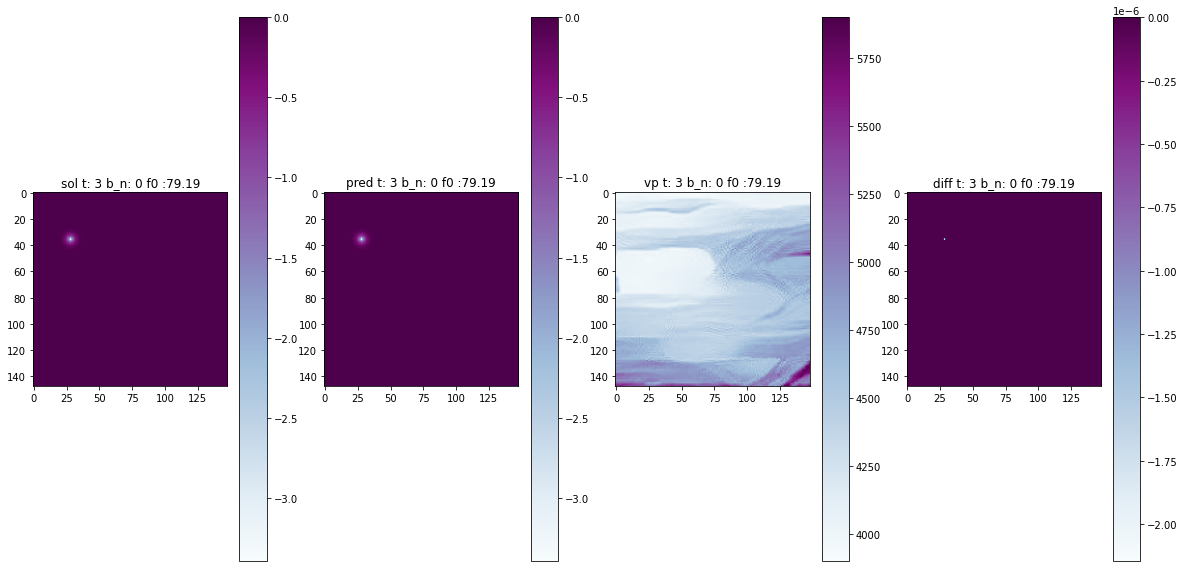

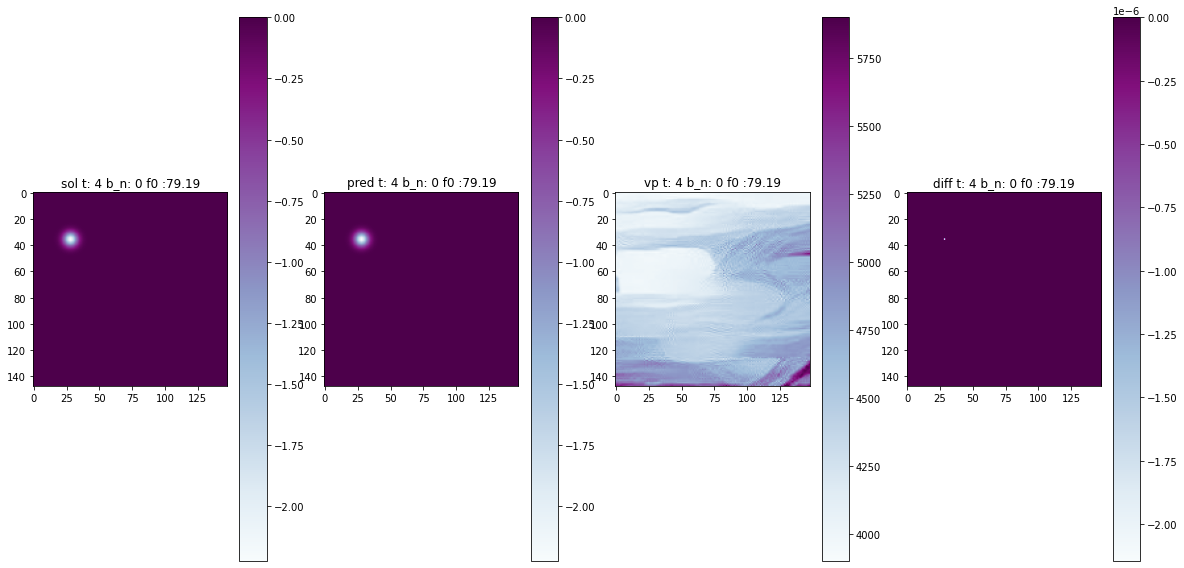

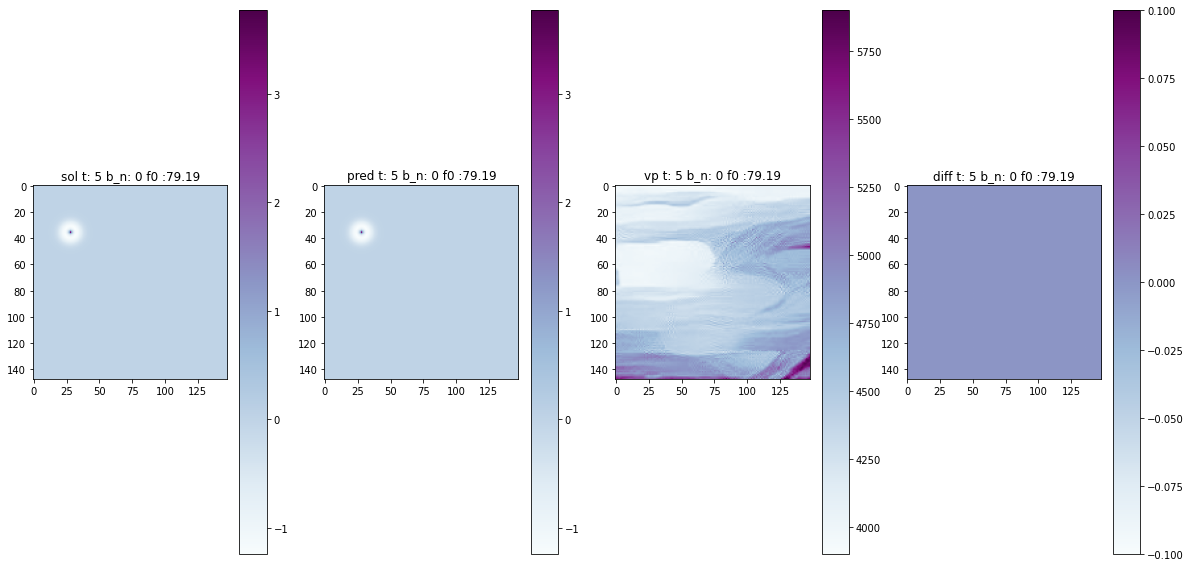

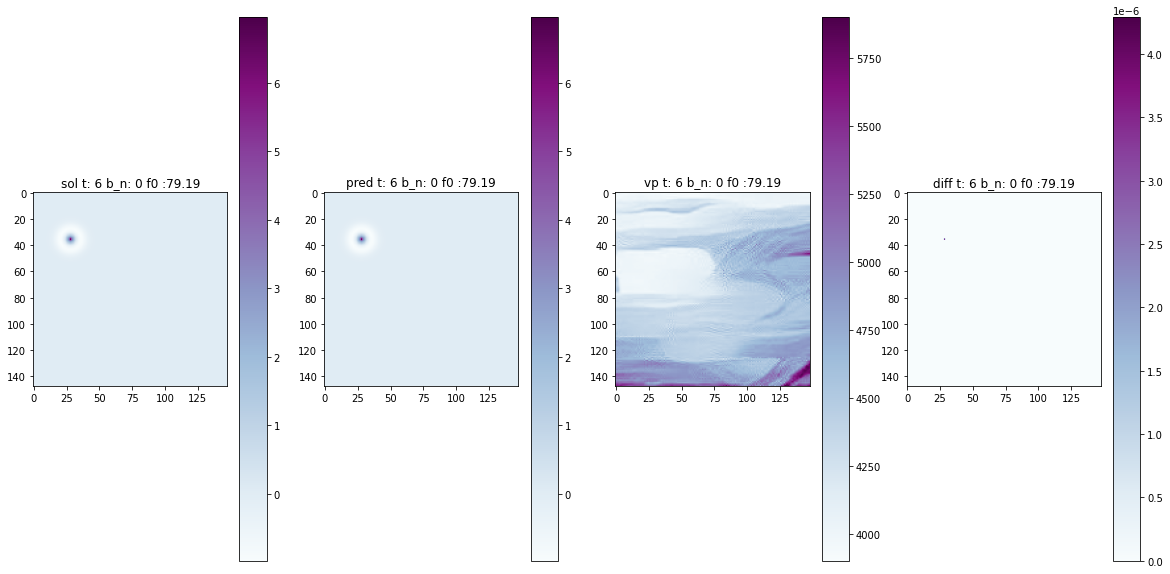

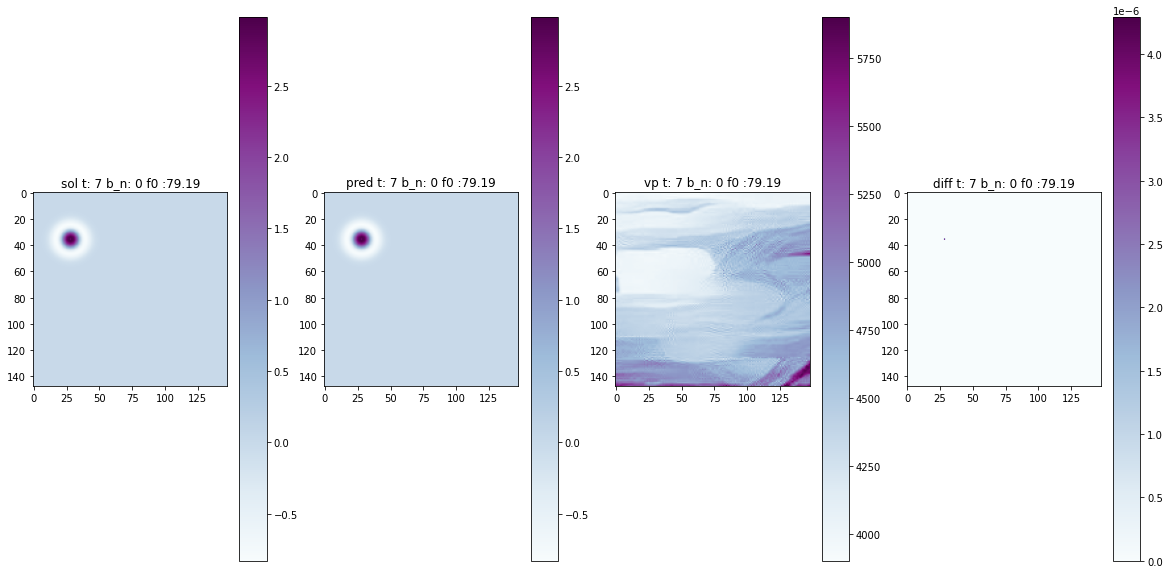

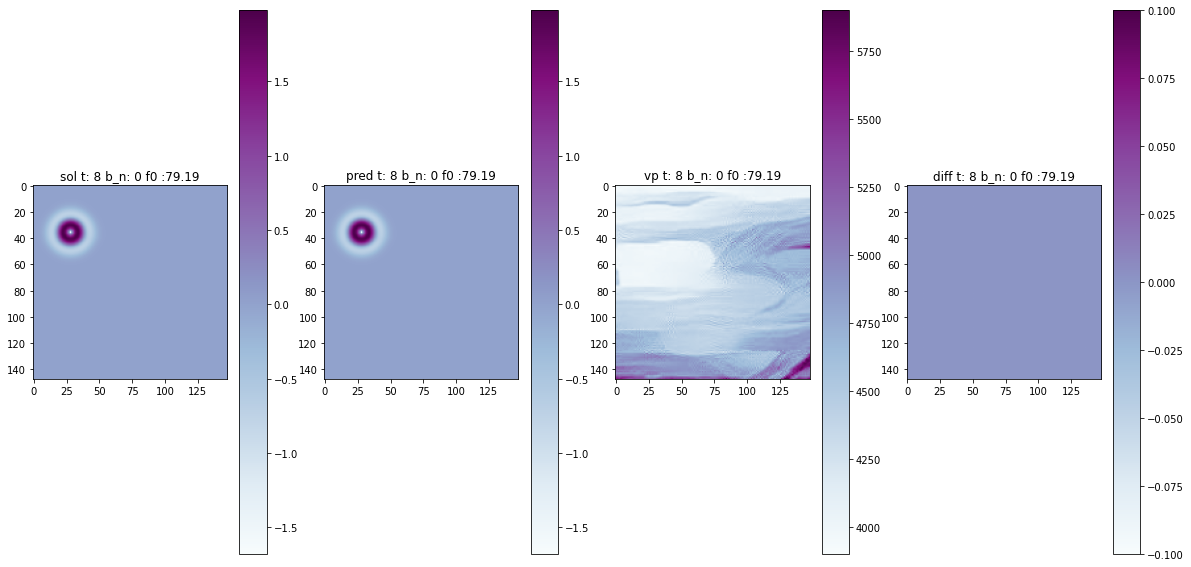

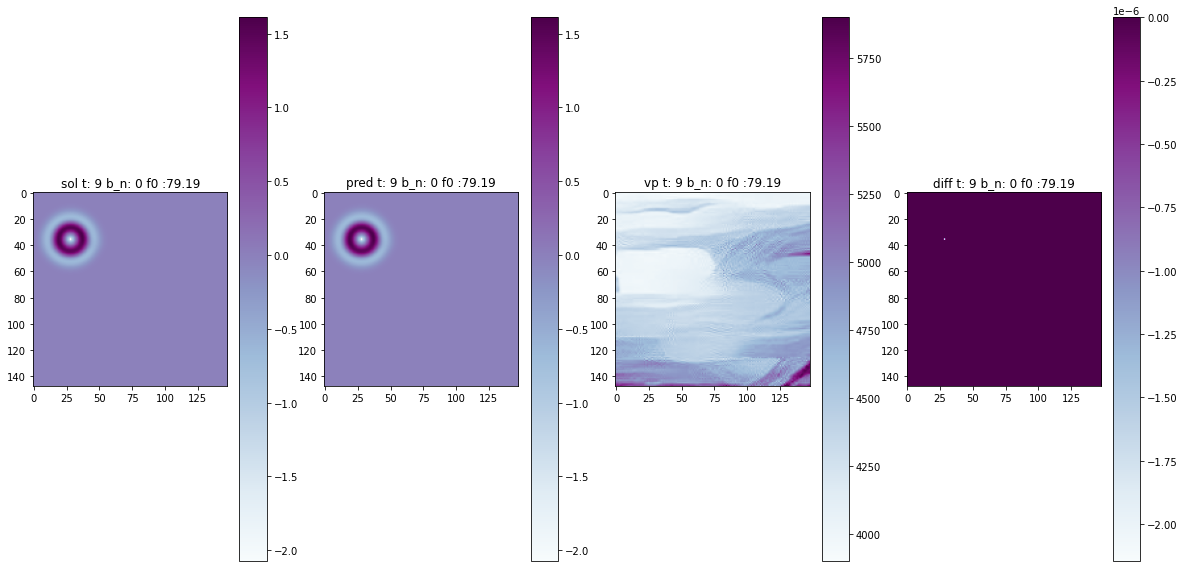

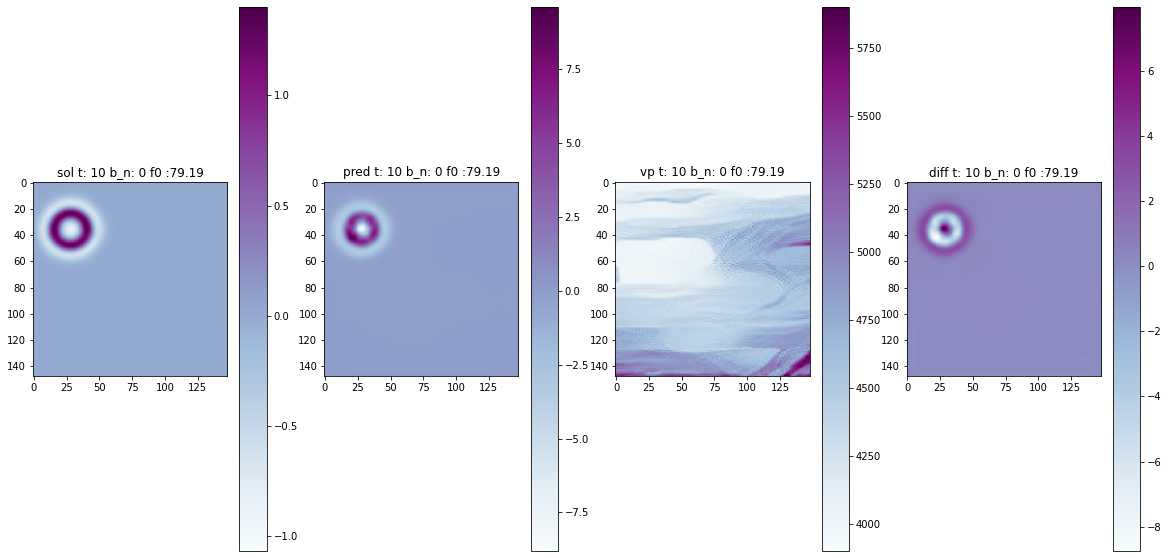

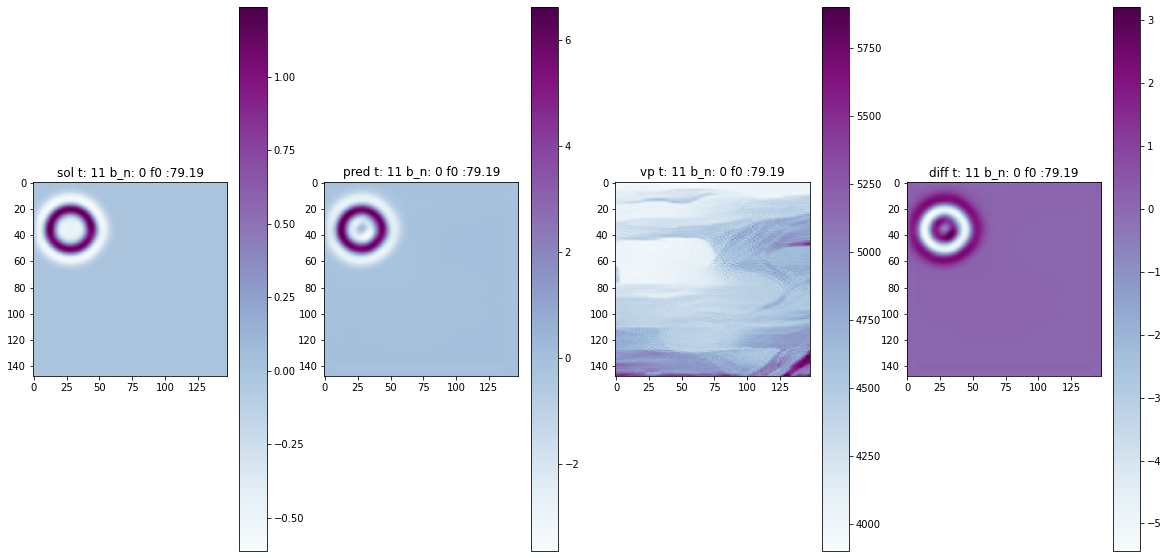

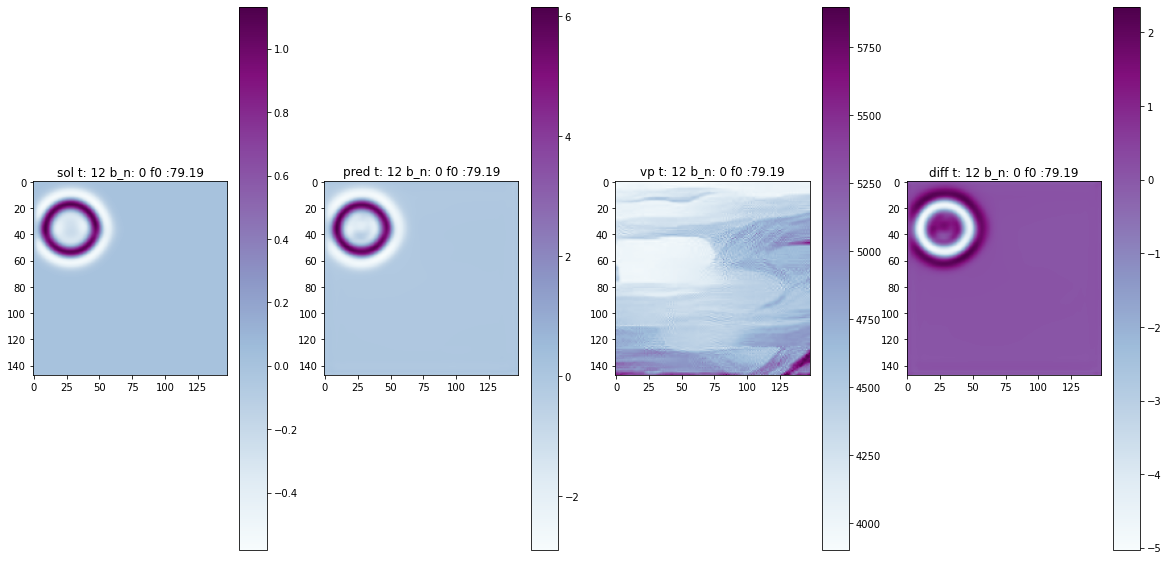

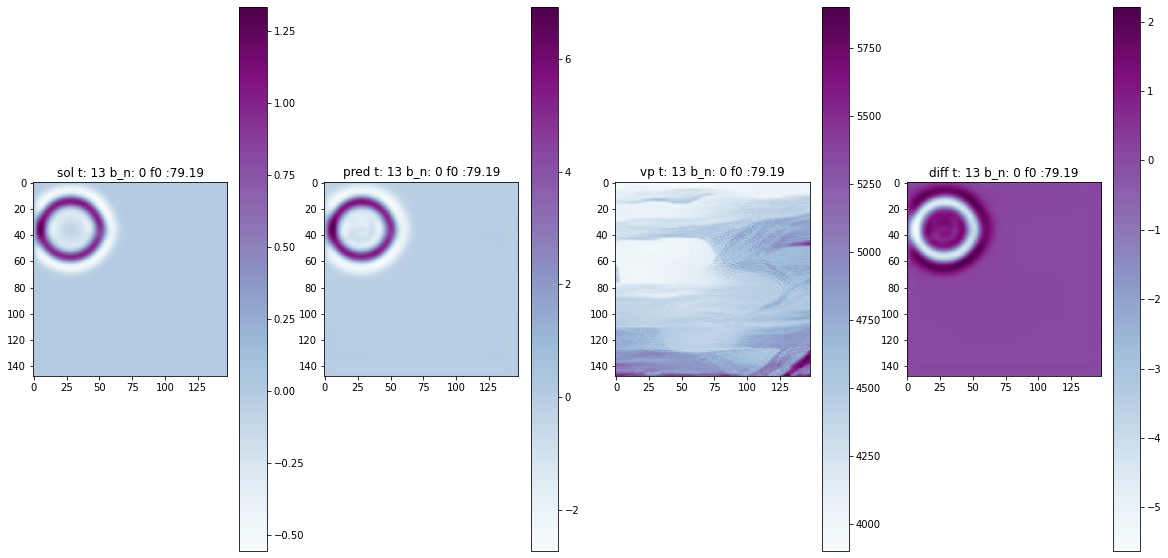

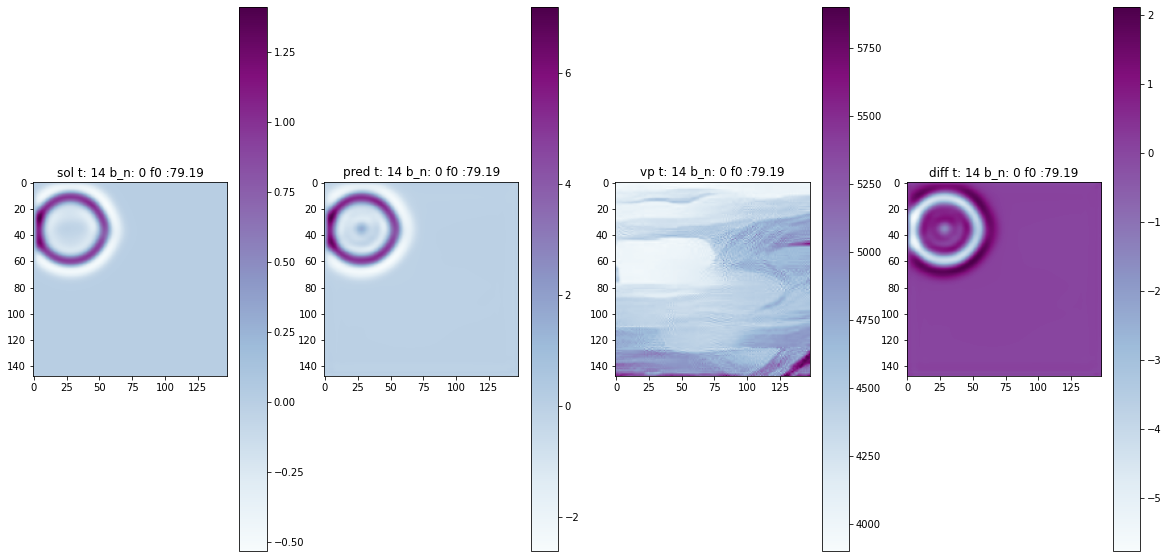

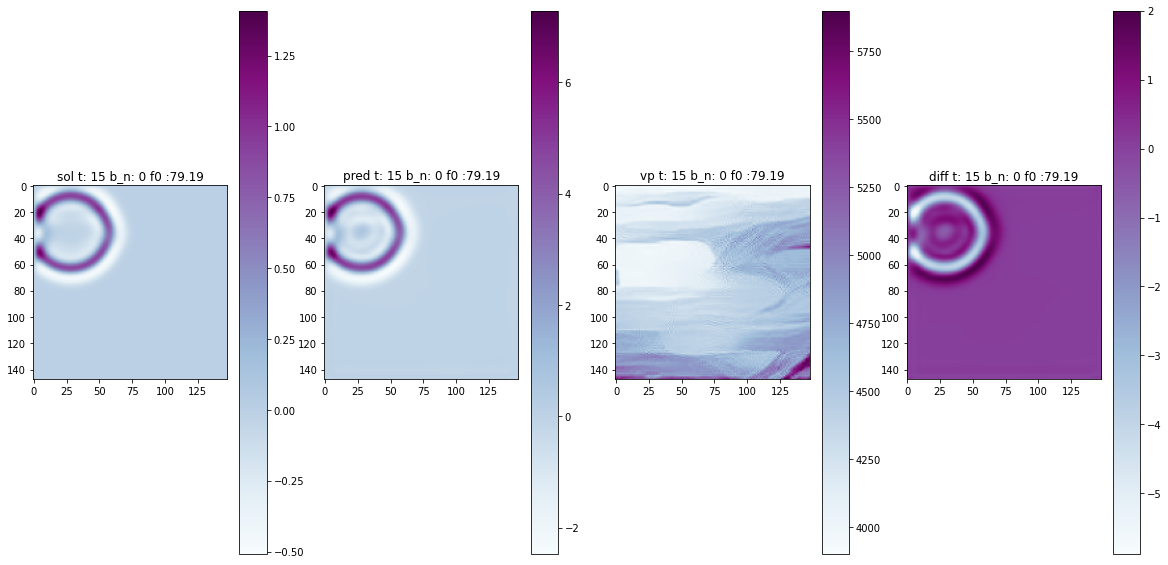

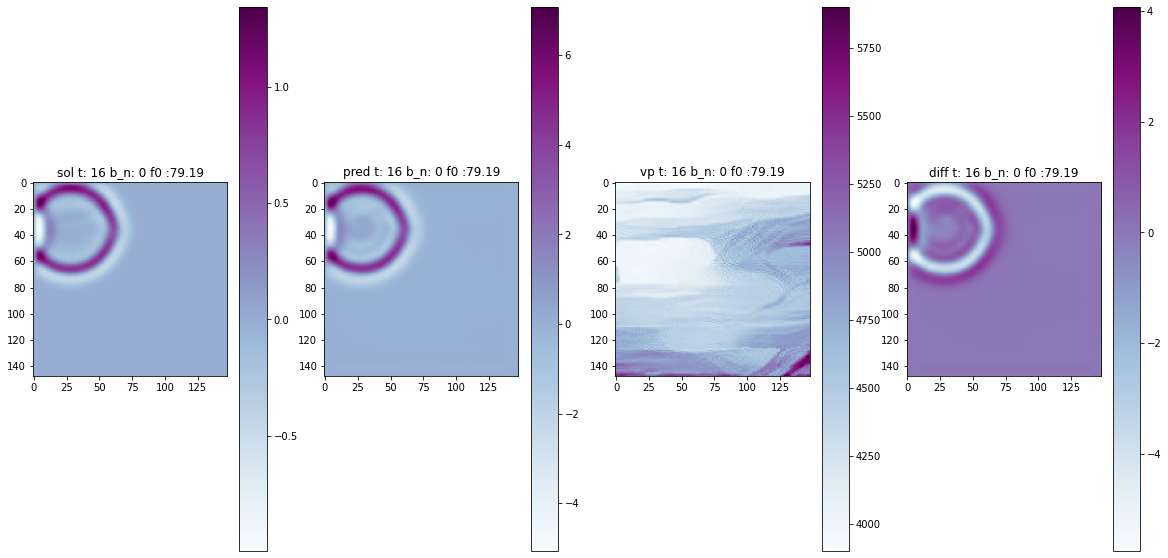

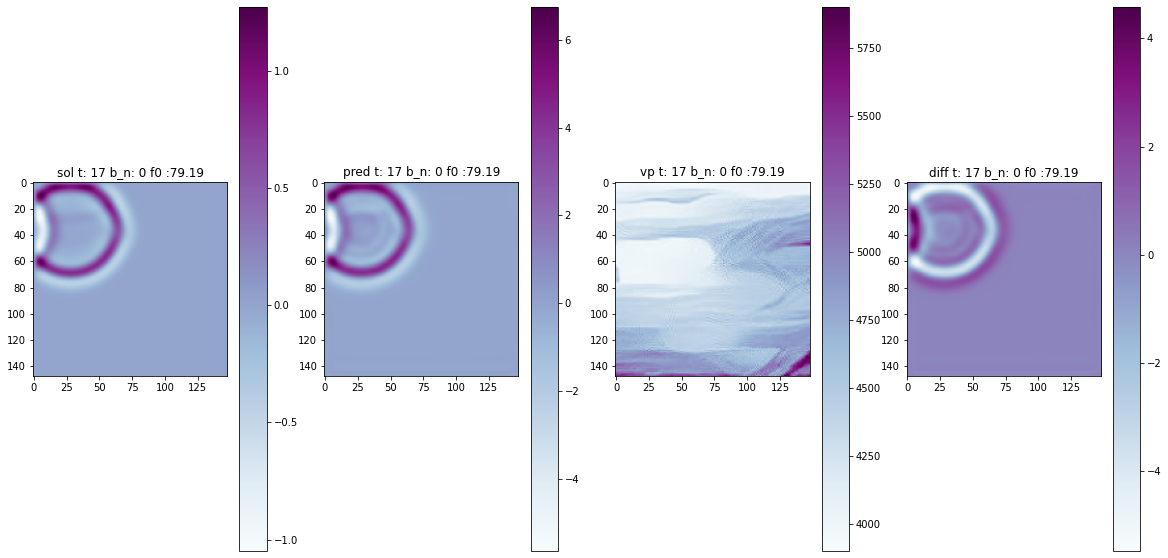

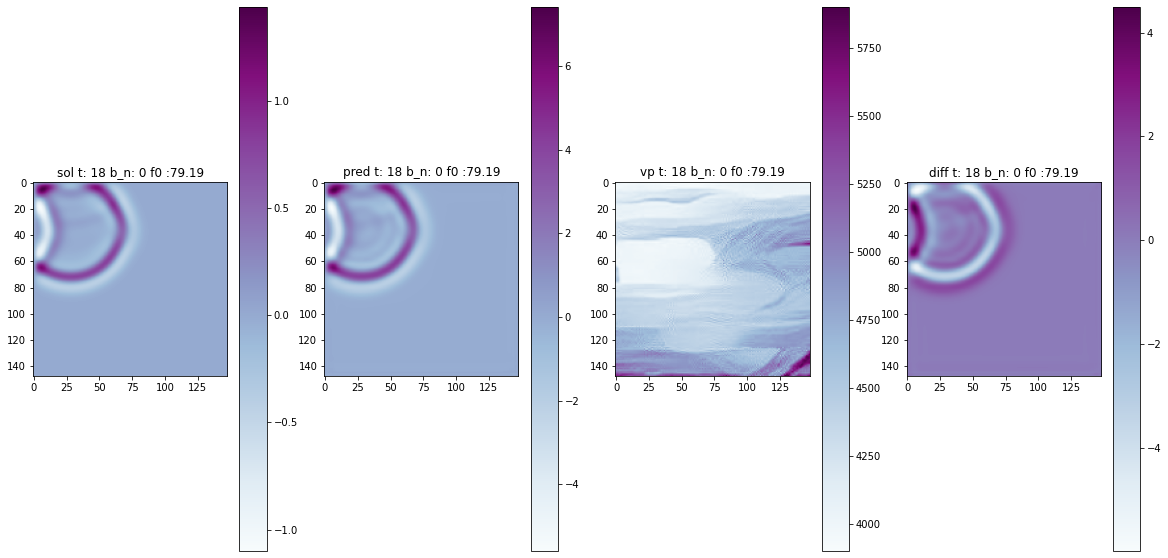

In [ ]:
predictions, u_labels, vp, f0_list = test_diff_model__(model, N_min=4, N_max=6, nx=148, nz=148, nt=20, batch_size=2, device=device)
plot_test_video(u_labels, predictions, vp, f0_list)